# Ensamble de modelos — Regresión Logística con SGD

In [1]:
import os, json, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support, classification_report, precision_recall_curve
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.calibration import CalibratedClassifierCV

## Configuración

In [2]:
PREDICTIONS_DIR = '../predictions'

GROUP_ID  = 'BeingChillingWeWillWin'
MODEL_ID  = 'ensemble'

label_map_inverse = {0: 'NO', 1: 'YES'}

SGD_LOSS       = 'log_loss'
SGD_PENALTY    = 'l2'
SGD_ALPHA      = 1e-4
SGD_MAX_ITER   = 1000
SGD_RANDOM_STATE = 42
N_CV_FOLDS     = 5

## Carga de probabilidades

In [3]:
def load_probs(path):
    """Carga un JSON de probs y devuelve un DataFrame con columnas: id, prob_YES, (label)."""
    with open(path, 'r', encoding='utf-8') as f:
        records = json.load(f)
    return pd.DataFrame(records)


def load_all_probs(split):
    """
    Carga todos los archivos BeingChillingWeWillWin_*_probs_{split}.json del directorio.
    Devuelve:
      - probs_matrix: DataFrame con una columna por modelo (index = id)
      - labels: Serie con las etiquetas reales (solo para dev)
      - model_names: lista de nombres de modelos encontrados
    """
    pattern = os.path.join(PREDICTIONS_DIR, f'BeingChillingWeWillWin_*_probs_{split}.json')
    files   = sorted(glob.glob(pattern))

    if not files:
        raise FileNotFoundError(f'No se encontraron archivos con patrón: {pattern}')

    print(f'\nArchivos encontrados para {split.upper()}:')
    all_dfs, model_names = [], []
    labels = None

    for fpath in files:
        model_name = os.path.basename(fpath).replace(f'_probs_{split}.json', '')
        model_names.append(model_name)
        df = load_probs(fpath).set_index('id')
        print(f'  [{model_name}]  {len(df)} ejemplos')

        if split == 'dev' and 'label' in df.columns:
            if labels is None:
                labels = df['label'].map({'NO': 0, 'YES': 1})
            df = df.drop(columns=['label'])

        all_dfs.append(df.rename(columns={'prob_YES': model_name}))

    probs_matrix = pd.concat(all_dfs, axis=1)
    print(f'\nMatrix de probs ({split}): {probs_matrix.shape}  →  {len(files)} modelos')
    return probs_matrix, labels, model_names


dev_probs_matrix,  dev_labels,  model_names = load_all_probs('dev')
test_probs_matrix, _,           _           = load_all_probs('test')


Archivos encontrados para DEV:
  [BeingChillingWeWillWin_MLPsensorial]  537 ejemplos
  [BeingChillingWeWillWin_dinov3ViTL16Img]  537 ejemplos
  [BeingChillingWeWillWin_f2llm4BImgtext]  537 ejemplos

Matrix de probs (dev): (537, 3)  →  3 modelos

Archivos encontrados para TEST:
  [BeingChillingWeWillWin_MLPsensorial]  687 ejemplos
  [BeingChillingWeWillWin_dinov3ViTL16Img]  687 ejemplos
  [BeingChillingWeWillWin_f2llm4BImgtext]  687 ejemplos

Matrix de probs (test): (687, 3)  →  3 modelos


NaN en dev matrix: 0
NaN en test matrix: 0


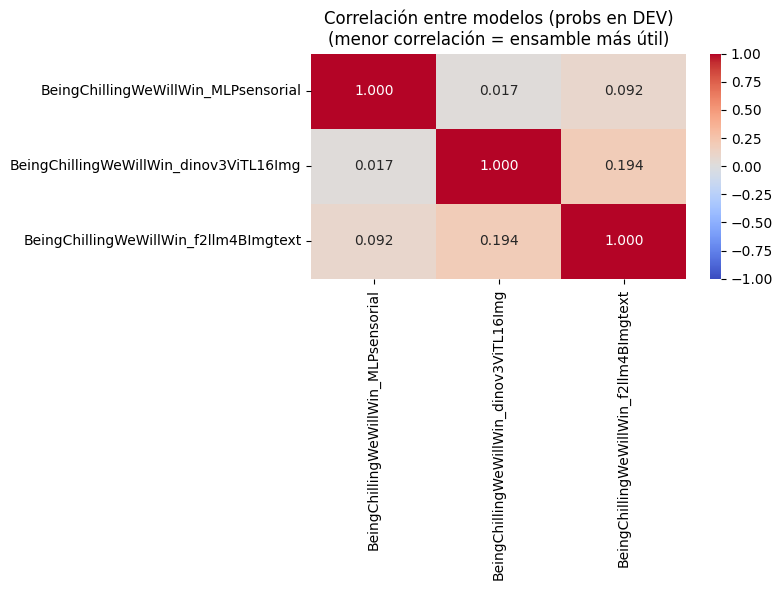

In [4]:
print('NaN en dev matrix:', dev_probs_matrix.isna().sum().sum())
print('NaN en test matrix:', test_probs_matrix.isna().sum().sum())

if len(model_names) > 1:
    plt.figure(figsize=(8, 6))
    sns.heatmap(dev_probs_matrix.corr(), annot=True, fmt='.3f', cmap='coolwarm', center=0, vmin=-1, vmax=1)
    plt.title('Correlación entre modelos (probs en DEV)\n(menor correlación = ensamble más útil)')
    plt.tight_layout(); plt.show()
else:
    print('Solo hay 1 modelo, no hay correlación que mostrar.')

## Ensamble con Regresión Logística (SGD)

Cada columna de `probs_matrix` (la probabilidad `prob_YES` de cada modelo base)
se usa como **feature** para entrenar una regresión logística con SGD.
El entrenamiento se hace **solo en DEV** con validación cruzada estratificada,
y el modelo final entrenado en todo DEV se aplica a TEST.

In [5]:
# ── Preparar matrices X, y ─────────────────────────────────────────────────────
X_dev  = dev_probs_matrix[model_names].values    # (n_dev,  n_models)
y_dev  = dev_labels.loc[dev_probs_matrix.index].values  # (n_dev,)
X_test = test_probs_matrix[model_names].values   # (n_test, n_models)

print(f'Distribución DEV → YES: {y_dev.sum()} | NO: {(y_dev==0).sum()}')

Distribución DEV → YES: 321 | NO: 216


In [6]:
sgd_clf = SGDClassifier(
    loss=SGD_LOSS,
    penalty=SGD_PENALTY,
    alpha=SGD_ALPHA,
    max_iter=SGD_MAX_ITER,
    random_state=SGD_RANDOM_STATE,
    class_weight='balanced',
    tol=1e-4,
)

ensemble_pipeline = Pipeline([
    ('clf',    sgd_clf)
])

print('Pipeline definido:')
print(ensemble_pipeline)

Pipeline definido:
Pipeline(steps=[('clf',
                 SGDClassifier(class_weight='balanced', loss='log_loss',
                               random_state=42, tol=0.0001))])


### Cross-validación en DEV para estimar F1

In [7]:
cv = StratifiedKFold(n_splits=N_CV_FOLDS, shuffle=True, random_state=SGD_RANDOM_STATE)

cv_f1  = cross_val_score(ensemble_pipeline, X_dev, y_dev, cv=cv, scoring='f1')
cv_auc = cross_val_score(ensemble_pipeline, X_dev, y_dev, cv=cv, scoring='roc_auc')

print(f'Cross-val F1  ({N_CV_FOLDS} folds): {cv_f1.mean():.4f} ± {cv_f1.std():.4f}')
print(f'Cross-val AUC ({N_CV_FOLDS} folds): {cv_auc.mean():.4f} ± {cv_auc.std():.4f}')

Cross-val F1  (5 folds): 0.7837 ± 0.0286
Cross-val AUC (5 folds): 0.7934 ± 0.0105


### Entrenamiento final en todo DEV

In [8]:
ensemble_pipeline.fit(X_dev, y_dev)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"loss loss: {'hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'}, default='hinge'The loss function to be used.- 'hinge' gives a linear SVM.- 'log_loss' gives logistic regression, a probabilistic classifier.- 'modified_huber' is another smooth loss that brings tolerance to outliers as well as probability estimates.- 'squared_hinge' is like hinge but is quadratically penalized.- 'perceptron' is the linear loss used by the perceptron algorithm.- The other losses, 'squared_error', 'huber', 'epsilon_insensitive' and 'squared_epsilon_insensitive' are designed for regression but can be useful in classification as well; see :class:`~sklearn.linear_model.SGDRegressor` for a description.More details about the losses formulas can be found in the :ref:`User Guide` and you can find a visualisation of the lossfunctions in:ref:`sphx_glr_auto_examples_linear_model_plot_sgd_loss_functions.py`.",'log_loss'
,"penalty penalty: {'l2', 'l1', 'elasticnet', None}, default='l2'The penalty (aka regularization term) to be used. Defaults to 'l2'which is the standard regularizer for linear SVM models. 'l1' and'elasticnet' might bring sparsity to the model (feature selection)not achievable with 'l2'. No penalty is added when set to `None`.You can see a visualisation of the penalties in:ref:`sphx_glr_auto_examples_linear_model_plot_sgd_penalties.py`.",'l2'
,"alpha alpha: float, default=0.0001Constant that multiplies the regularization term. The higher thevalue, the stronger the regularization. Also used to compute thelearning rate when `learning_rate` is set to 'optimal'.Values must be in the range `[0.0, inf)`.",0.0001
,"l1_ratio l1_ratio: float, default=0.15The Elastic Net mixing parameter, with 0 <= l1_ratio <= 1.l1_ratio=0 corresponds to L2 penalty, l1_ratio=1 to L1.Only used if `penalty` is 'elasticnet'.Values must be in the range `[0.0, 1.0]` or can be `None` if`penalty` is not `elasticnet`... versionchanged:: 1.7 `l1_ratio` can be `None` when `penalty` is not ""elasticnet"".",0.15
,"fit_intercept fit_intercept: bool, default=TrueWhether the intercept should be estimated or not. If Fal

## Threshold Óptimo sobre DEV

In [9]:
dev_ensemble_probs  = ensemble_pipeline.predict_proba(X_dev)[:, 1]

fpr, tpr, thresholds = roc_curve(y_dev, dev_ensemble_probs)
roc_auc           = auc(fpr, tpr)

precisions, recalls, thresholds = precision_recall_curve(y_dev, dev_ensemble_probs)
f1_scores         = (2 * precisions * recalls) / (precisions + recalls + 1e-10)
optimal_idx       = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f'AUC (DEV ensamble SGD): {roc_auc:.4f}')
print(f'Mejor Threshold:        {optimal_threshold:.4f}')
print(f'TPR:                    {tpr[optimal_idx]:.4f}')
print(f'FPR:                    {fpr[optimal_idx]:.4f}')

dev_preds_optimal = (dev_ensemble_probs >= optimal_threshold).astype(int)
precision_opt, recall_opt, f1_opt, _ = precision_recall_fscore_support(
    y_dev, dev_preds_optimal, average='macro', zero_division=0)
acc_opt = accuracy_score(y_dev, dev_preds_optimal)

print(f'\nMétricas en DEV con threshold óptimo ({optimal_threshold:.4f}):')
print(f'  Accuracy:  {acc_opt:.4f}')
print(f'  Precision: {precision_opt:.4f}')
print(f'  Recall:    {recall_opt:.4f}')
print(f'  F1-Score:  {f1_opt:.4f}')

AUC (DEV ensamble SGD): 0.7983
Mejor Threshold:        0.2587
TPR:                    0.8255
FPR:                    0.3704

Métricas en DEV con threshold óptimo (0.2587):
  Accuracy:  0.7412
  Precision: 0.7857
  Recall:    0.6896
  F1-Score:  0.6923


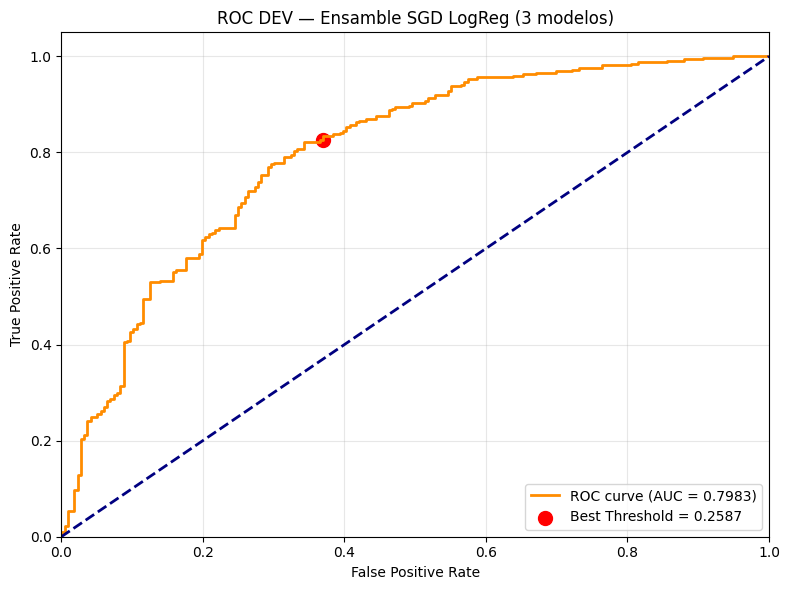

In [10]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red',
            label=f'Best Threshold = {optimal_threshold:.4f}', s=100)
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title(f'ROC DEV — Ensamble SGD LogReg ({len(model_names)} modelos)')
plt.legend(loc='lower right'); plt.grid(alpha=0.3)
plt.tight_layout(); plt.show()

In [11]:
print('Classification Report (DEV, ensamble SGD, threshold óptimo):')
print(classification_report(y_dev, dev_preds_optimal, target_names=['NO', 'YES']))

Classification Report (DEV, ensamble SGD, threshold óptimo):
              precision    recall  f1-score   support

          NO       0.86      0.43      0.57       216
         YES       0.71      0.95      0.81       321

    accuracy                           0.74       537
   macro avg       0.79      0.69      0.69       537
weighted avg       0.77      0.74      0.72       537



## Predicción final sobre TEST y Guardado

In [12]:
test_ids   = test_probs_matrix.index.tolist()
test_ensemble_probs = ensemble_pipeline.predict_proba(X_test)[:, 1]
test_preds = (test_ensemble_probs >= optimal_threshold).astype(int)

print(f'Test → YES: {test_preds.sum()} | NO: {(test_preds == 0).sum()}')

test_preds_for_submission = [
    {'test_case': 'EXIST2025', 'id': str(id_exist), 'value': label_map_inverse[pred]}
    for id_exist, pred in zip(test_ids, test_preds)
]

test_preds_df = pd.DataFrame(test_preds_for_submission)
output_path   = os.path.join(PREDICTIONS_DIR, f'{GROUP_ID}_{MODEL_ID}.json')

with open(output_path, 'w', encoding='utf-8') as output_file:
    output_file.write(test_preds_df.to_json(orient='records'))

print(f'\nPredicciones guardadas en: {output_path}')

Test → YES: 542 | NO: 145

Predicciones guardadas en: ../predictions/BeingChillingWeWillWin_ensemble.json
